<a href="https://www.kaggle.com/code/tanishktyagi/human-activity-recognition-using-video?scriptVersionId=236080719" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## <h1><center><b>Human Activity Recognition From Videos</b></center></h1>

<img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fuser-images.githubusercontent.com%2F46052843%2F191772606-f599c270-97b2-43a9-ab91-563b4dc6a882.png&f=1&nofb=1&ipt=70eef176a1e6e40ecb7676201db2d9717ab69290ba8dae9946d027b17e7c4bea&ipo=images" alt=center>


# **Steps**

### 1. Import require library
### 2. Summarize the dataset
### 3. Visualize the dataset with labels
### 4. Preprocess the dataset 
### 5. Split the dataset into train and test
### 6. Design and Develop dnn architecture and train the model
### 7. Testing the model
### 8. Report the result
### 9. Predict the output

# 1. Import the required libraries

In [1]:
%%capture
!pip install tensorflow opencv-contrib-python pydot moviepy pafy

!pip install pafy youtube-dl moviepy

In [2]:
# Import the required libraries.
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
#Seeds to get consistent results on every execution
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

# 2. Data Acquisition


Dataset url: https://www.crcv.ucf.edu/data/UCF50.php

Dataset summary:


*   **`50`** Action Categories

*   **`25`** Groups of Videos per Action Category

*   **`133`** Average Videos per Action Category

*   **`199`** Average Number of Frames per Video

*   **`320`** Average Frames Width per Video

*   **`240`** Average Frames Height per Video

*   **`26`** Average Frames Per Seconds per Video



## Visualize the data with its label

In [4]:
all_classes_names = os.listdir('/kaggle/input/human-activity-recognition-ucf50-video-dataset/UCF50')
print(all_classes_names)

['HorseRace', 'VolleyballSpiking', 'Biking', 'TaiChi', 'Punch', 'BreastStroke', 'Billiards', 'PoleVault', 'ThrowDiscus', 'BaseballPitch', 'HorseRiding', 'Mixing', 'HighJump', 'Skijet', 'SkateBoarding', 'MilitaryParade', 'Fencing', 'JugglingBalls', 'Swing', 'RockClimbingIndoor', 'SalsaSpin', 'PlayingTabla', 'Rowing', 'BenchPress', 'PushUps', 'Nunchucks', 'PlayingViolin', 'PullUps', 'PlayingPiano', 'HulaHoop', 'RopeClimbing', 'YoYo', 'TrampolineJumping', 'JumpingJack', 'Drumming', 'GolfSwing', 'PlayingGuitar', 'PizzaTossing', 'Lunges', 'TennisSwing', 'WalkingWithDog', 'Kayaking', 'PommelHorse', 'Basketball', 'JumpRope', 'CleanAndJerk', 'Skiing', 'Diving', 'SoccerJuggling', 'JavelinThrow']


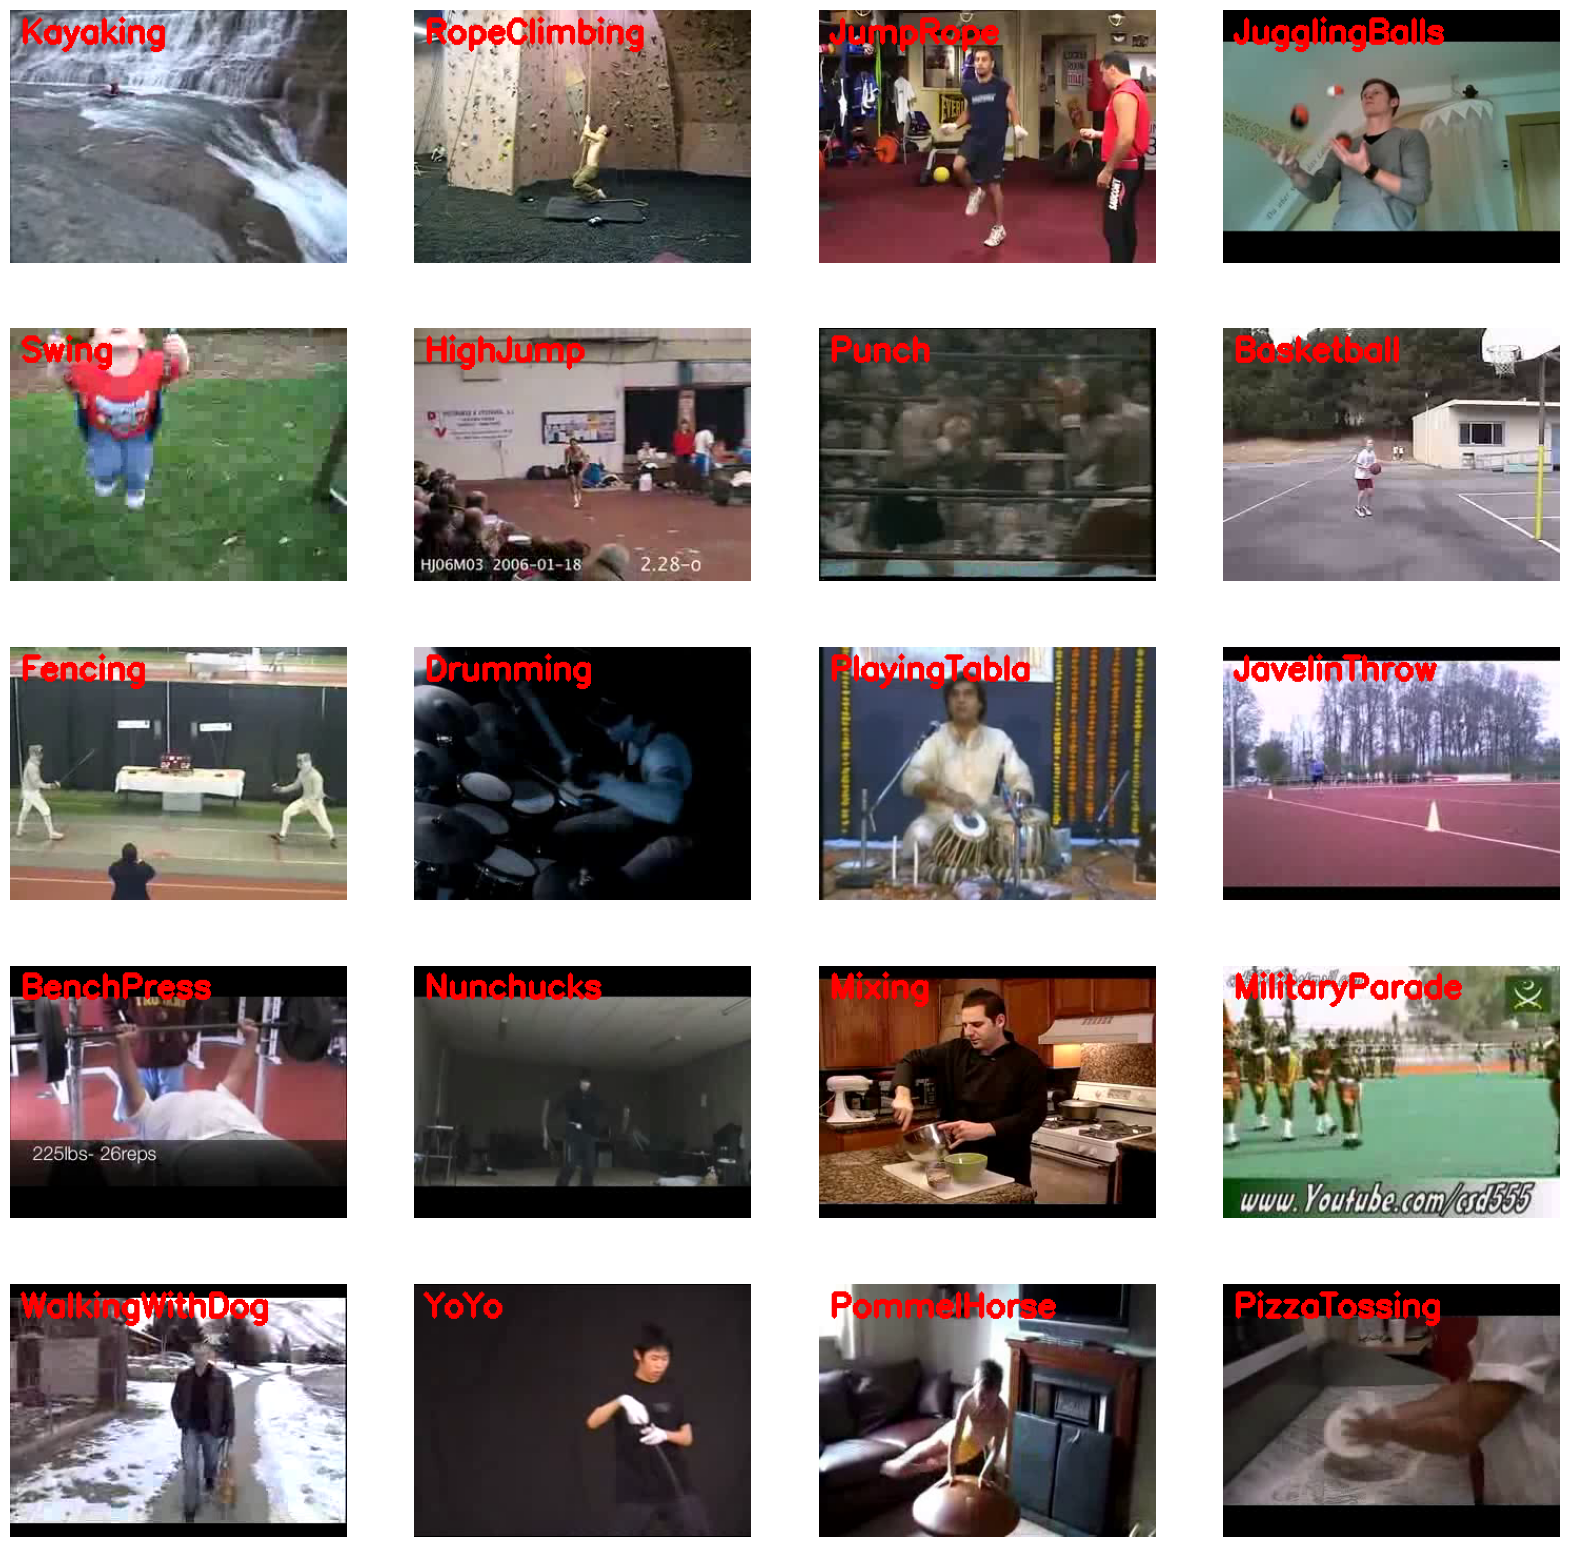

In [5]:
plt.figure(figsize = (20, 20))

all_classes_names = os.listdir(f'/kaggle/input/human-activity-recognition-ucf50-video-dataset/UCF50/')

random_range = random.sample(range(len(all_classes_names)),20)

for counter, random_index in enumerate(random_range, 1):
    selected_class_Name = all_classes_names[random_index]
    video_files_names_list = os.listdir(f'/kaggle/input/human-activity-recognition-ucf50-video-dataset/UCF50/{selected_class_Name}')
    selected_video_file_name = random.choice(video_files_names_list)
    video_reader = cv2.VideoCapture(f'/kaggle/input/human-activity-recognition-ucf50-video-dataset/UCF50/{selected_class_Name}/{selected_video_file_name}')
    _, bgr_frame = video_reader.read()
    video_reader.release()
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 3)
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

# 3. Data Preparation


In [6]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 20
DATASET_DIR = "/kaggle/input/human-activity-recognition-ucf50-video-dataset/UCF50"
# I am trying specific 5 classes (For system constrain)
CLASSES_LIST = ['HorseRace', 'VolleyballSpiking', 'Biking', 'TaiChi', 'Punch', 'BreastStroke', 'Billiards', 'PoleVault', 'ThrowDiscus', 'BaseballPitch', 'HorseRiding', 'Mixing', 'HighJump', 'Skijet', 'SkateBoarding', 'MilitaryParade', 'Fencing', 'JugglingBalls', 'Swing', 'RockClimbingIndoor', 'SalsaSpin', 'PlayingTabla', 'Rowing', 'BenchPress', 'PushUps', 'Nunchucks', 'PlayingViolin']
print("My specific classes count:",len(CLASSES_LIST))

My specific classes count: 27


### **Helper function**

1. Extract and normalize the dataset
2. Create a Function for Dataset Creation
3. Plot Model's Loss & Accuracy Curves

In [7]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()
        if not success:
            break
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)
    video_reader.release()

    return frames_list

In [8]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''
    features = []
    labels = []
    video_files_paths = []
    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = frames_extraction(video_file_path)
            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
    features = np.asarray(features)
    labels = np.array(labels)
    return features, labels, video_files_paths

In [9]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    epochs = range(len(metric_value_1))
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
    plt.title(str(plot_name))
    plt.legend()

### **Create the dataset**

In [10]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: HorseRace
Extracting Data of Class: VolleyballSpiking
Extracting Data of Class: Biking
Extracting Data of Class: TaiChi
Extracting Data of Class: Punch
Extracting Data of Class: BreastStroke
Extracting Data of Class: Billiards
Extracting Data of Class: PoleVault
Extracting Data of Class: ThrowDiscus
Extracting Data of Class: BaseballPitch
Extracting Data of Class: HorseRiding
Extracting Data of Class: Mixing
Extracting Data of Class: HighJump
Extracting Data of Class: Skijet
Extracting Data of Class: SkateBoarding
Extracting Data of Class: MilitaryParade
Extracting Data of Class: Fencing
Extracting Data of Class: JugglingBalls
Extracting Data of Class: Swing
Extracting Data of Class: RockClimbingIndoor
Extracting Data of Class: SalsaSpin
Extracting Data of Class: PlayingTabla
Extracting Data of Class: Rowing
Extracting Data of Class: BenchPress
Extracting Data of Class: PushUps
Extracting Data of Class: Nunchucks
Extracting Data of Class: PlayingViolin


### **Using Keras's to_categorical method to convert labels into one-hot-encoded vectors**


In [11]:
one_hot_encoded_labels = to_categorical(labels)

### **Split the Data into Train and Test Set**

In [12]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.20, shuffle = True,
                                                                            random_state = seed_constant)

## 4. Deep Neural Network Architecture

## 4.1 Design the architecture that you will be using LRCN


we will implement an approach known as the Long-term Recurrent Convolutional Network (LRCN), that combines CNN and LSTM layers in a single model. The Convolutional layers are used for spatial feature extraction from the frames, and the extracted spatial features are fed to LSTM layers at each time-steps for temporal sequence modeling. This way the network learns spatiotemporal features directly in an end-to-end training, resulting in a robust model.

<center>
<img src='https://i.stack.imgur.com/FuxJA.png'>
</center>

As part of the solution, we will also put TimeDistributed wrapper layer to use, which allows applying the same layer to every frame of the video independently. This makes a layer (around which it is wrapped) capable of taking input of shape no_of_frames, width, height, num_of_channels if originally the layer's input shape was width, height, num_of_channels. This is very beneficial as it allows us to input the whole video into the model in a single shot.


In [13]:
#Build the model

def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    model = Sequential()

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    print("Report of Model layer & parameters:")
    model.summary()

    return model

In [14]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()
print("Model Created Successfully")

Report of Model layer & parameters:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 20, 64, 64, 16)    448       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 20, 16, 16, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 20, 16, 16, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 20, 16, 16, 32)    4640      
 stributed)                                                      
                                                                 
 time_distributed_4 

# 5. Training the model 

In [15]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 5, batch_size = 8 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/5


2025-04-25 14:31:56.237547: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/time_distributed_2/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


286/286 [==============================] - 11s 19ms/step - loss: 3.2266 - accuracy: 0.0835 - val_loss: 3.0556 - val_accuracy: 0.1259
Epoch 2/5
286/286 [==============================] - 3s 12ms/step - loss: 2.8574 - accuracy: 0.1626 - val_loss: 2.6265 - val_accuracy: 0.2290
Epoch 3/5
286/286 [==============================] - 3s 11ms/step - loss: 2.5664 - accuracy: 0.2469 - val_loss: 2.7459 - val_accuracy: 0.2238
Epoch 4/5
286/286 [==============================] - 3s 11ms/step - loss: 2.3646 - accuracy: 0.3038 - val_loss: 2.2928 - val_accuracy: 0.3164
Epoch 5/5
286/286 [==============================] - 3s 11ms/step - loss: 2.1912 - accuracy: 0.3475 - val_loss: 2.2044 - val_accuracy: 0.3462


# 6. Test the model


In [16]:
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

23/23 [==============================] - 1s 20ms/step - loss: 2.1506 - accuracy: 0.3645


# 7. Report the result

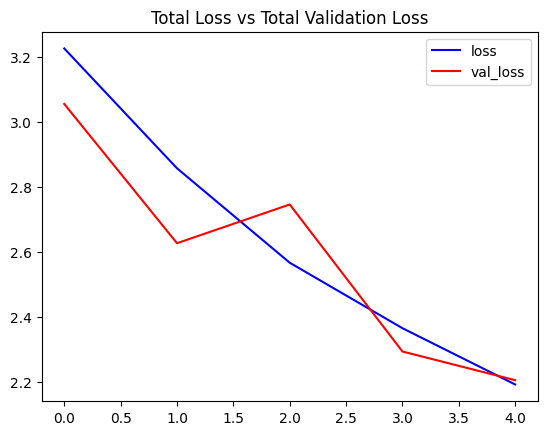

In [17]:
#Loss
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

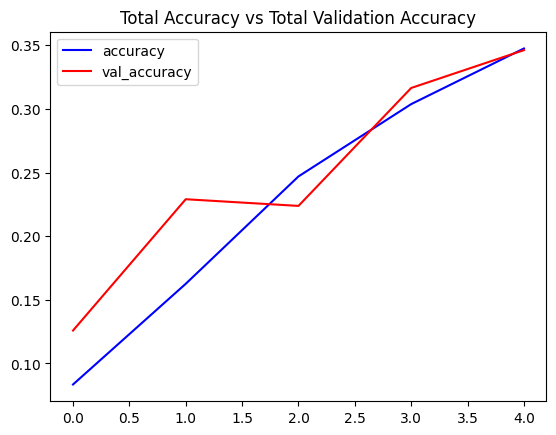

In [18]:
#Accuracy
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [19]:
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

23/23 [==============================] - 0s 16ms/step - loss: 2.1506 - accuracy: 0.3645


In [20]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

#prediction
predictions = LRCN_model.predict(features_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(labels_test, axis=1)

# confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print the confusion matrix
print("Confusion Matrix:\n", conf_matrix)


23/23 [==============================] - 1s 14ms/step
Confusion Matrix:
 [[15  1  0  0  1  0  0  1  0  1  4  0  0  0  0  1  1  0  0  1  0  1  1  0
   0  0  0]
 [ 8  1  0  0  0  0  0  1  0  2  2  2  4  0  0  0  0  1  2  2  0  0  0  0
   0  0  1]
 [ 0  0  2  0  1  0  0  0  0  1  8  0  0  1  0  3  0  2  1  2  1  3  5  0
   0  1  0]
 [ 5  0  0  0  1  0  0  0  0  2  7  0  0  0  0  0  0  1  0  5  1  0  0  2
   0  0  0]
 [ 0  0  0  0 19  0  0  0  0  0  0  0  0  0  0  3  0  1  0  0  0 10  1  0
   0  0  3]
 [ 0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0
   0  0  0]
 [ 0  0  0  0  0  0 22  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0
   0  0  0]
 [ 0  1  1  0  0  0  0 15  1  0  0  0  4  0  0  2  0  2  0  0  0  0  1  2
   0  0  1]
 [ 0  1  0  0  2  0  0  1  2  1  5  0  0  1  1  1  2  0  0  0  0  0  1  0
   0  0  0]
 [ 1  0  0  0  0  0  0  0  0 23  6  0  0  0  0  0  0  0  1  0  0  0  0  0
   0  0  0]
 [ 1  0  0  0  0  0  0  2  4  4 16  3  0  0  0  0  0  1  1  3  0  0

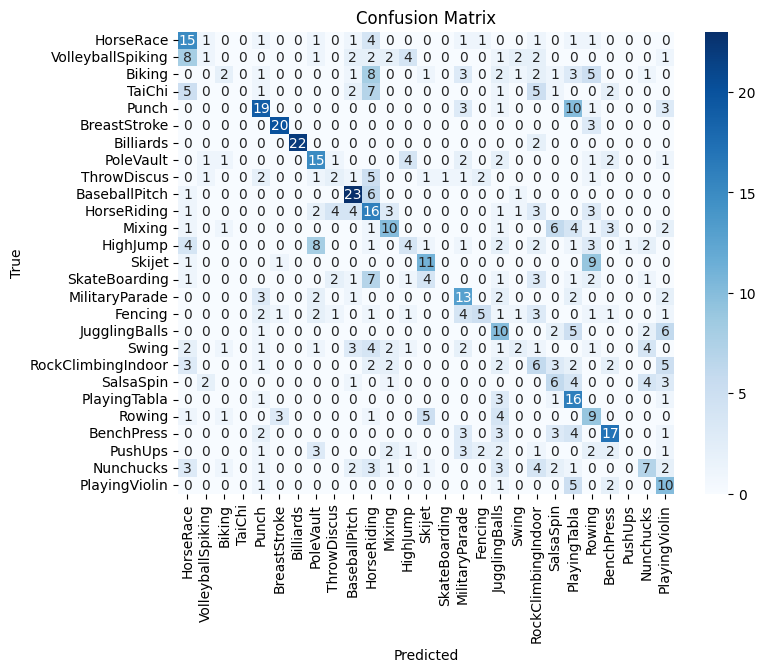

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

CLASSES_LIST = ['HorseRace', 'VolleyballSpiking', 'Biking', 'TaiChi', 'Punch', 'BreastStroke', 'Billiards', 'PoleVault', 'ThrowDiscus', 'BaseballPitch', 'HorseRiding', 'Mixing', 'HighJump', 'Skijet', 'SkateBoarding', 'MilitaryParade', 'Fencing', 'JugglingBalls', 'Swing', 'RockClimbingIndoor', 'SalsaSpin', 'PlayingTabla', 'Rowing', 'BenchPress', 'PushUps', 'Nunchucks', 'PlayingViolin']

# Assuming you already have predictions, true_labels, etc.

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES_LIST, yticklabels=CLASSES_LIST)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


### Save the Model

In [22]:
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

LRCN_model.save(model_file_name)

### Prediction


In [23]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    '''
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    output_file_path: The path where the ouput video with the predicted action being performed overlayed will be stored.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''
    video_reader = cv2.VideoCapture(video_file_path)
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)
    predicted_class_name = ''
    while video_reader.isOpened():
        ok, frame = video_reader.read()
        if not ok:
            break
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_queue.append(normalized_frame)
        if len(frames_queue) == SEQUENCE_LENGTH:
            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis = 0))[0]
            predicted_label = np.argmax(predicted_labels_probabilities)
            print(predicted_label)
            predicted_class_name = CLASSES_LIST[predicted_label]
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        video_writer.write(frame)
    video_reader.release()
    video_writer.release()

In [24]:
output_video_file_path = f'Output-SeqLen{SEQUENCE_LENGTH}.mp4'

input_video_file_path = r"/kaggle/input/human-activity-recognition-ucf50-video-dataset/UCF50/HorseRiding/v_HorseRiding_g01_c01.avi"

# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)


1/1 [==============================] - 0s 91ms/step


OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


0
1/1 [==============================] - 0s 20ms/step
0
1/1 [==============================] - 0s 19ms/step
0
1/1 [==============================] - 0s 19ms/step
0
1/1 [==============================] - 0s 20ms/step
0
1/1 [==============================] - 0s 19ms/step
0
1/1 [==============================] - 0s 19ms/step
0
1/1 [==============================] - 0s 19ms/step
0
1/1 [==============================] - 0s 19ms/step
0
1/1 [==============================] - 0s 20ms/step
0
1/1 [==============================] - 0s 20ms/step
0
1/1 [==============================] - 0s 20ms/step
0
1/1 [==============================] - 0s 18ms/step
0
1/1 [==============================] - 0s 19ms/step
0
1/1 [==============================] - 0s 20ms/step
0
1/1 [==============================] - 0s 20ms/step
0
1/1 [==============================] - 0s 20ms/step
0
1/1 [==============================] - 0s 20ms/step
0
1/1 [==============================] - 0s 19ms/step
0
1/1 [=====================

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# 1. Create the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(10,)),
    Dense(1, activation='sigmoid')
])

# 2. Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 3. Train the model (dummy data for example)
import numpy as np
X = np.random.rand(100, 10)
y = np.random.randint(2, size=(100, 1))

model.fit(X, y, epochs=5)

# 4. Now save the model
model.save("my_model.h5")


Epoch 1/5
4/4 [==============================] - 1s 4ms/step - loss: 0.6826 - accuracy: 0.5500
Epoch 2/5
4/4 [==============================] - 0s 3ms/step - loss: 0.6795 - accuracy: 0.5600
Epoch 3/5
4/4 [==============================] - 0s 3ms/step - loss: 0.6783 - accuracy: 0.5700
Epoch 4/5
4/4 [==============================] - 0s 3ms/step - loss: 0.6774 - accuracy: 0.5900
Epoch 5/5
4/4 [==============================] - 0s 3ms/step - loss: 0.6756 - accuracy: 0.6100


In [26]:
LRCN_model.save("my_model.h5")